In [69]:
# --- CELL 1: INSTALASI & LOGIN ---
!pip install geemap seaborn matplotlib

import ee
import geemap
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt
import numpy as np
from scipy import stats

# Login
try:
    ee.Initialize(project='aboveground-carbon-estimation')
    print("Login berhasil.")
except:
    ee.Authenticate()
    ee.Initialize(project='aboveground-carbon-estimation')
    print("Login manual berhasil.")

Login berhasil.


In [70]:
# --- CELL 2: FUNGSI CLOUD MASKING ---
def mask_s2_clouds(image):
    """
    Membersihkan awan tebal dan cirrus dari Sentinel-2
    menggunakan band QA60.
    """
    qa = image.select('QA60')
    cloud_bit_mask = 1 << 10
    cirrus_bit_mask = 1 << 11
    mask = qa.bitwiseAnd(cloud_bit_mask).eq(0) \
        .And(qa.bitwiseAnd(cirrus_bit_mask).eq(0))
    return image.updateMask(mask).divide(10000)

print("Fungsi masking siap.")

Fungsi masking siap.


In [72]:
# --- CELL 3: LOAD DATA (ROI) ---

# 1. Lokasi Studi (Basecamp REKI + Hutan Selatan/Barat Daya)
# Koordinat: [Barat, Selatan, Timur, Utara]
# Utara -2.0 (Basecamp masuk), Selatan -2.6 (Hutan dalam masuk)
roi = ee.Geometry.Rectangle([103.0, -2.6, 103.6, -2.0])

# 2. Data GEDI (Target)
# Ambil data 2019-2023 rata-rata
gedi_biomass = ee.ImageCollection("LARSE/GEDI/GEDI04_A_002_MONTHLY") \
    .filterBounds(roi) \
    .filterDate('2019-01-01', '2023-01-01') \
    .select('agbd') \
    .mean() \
    .clip(roi)

# Konversi ke Carbon (Faktor 0.47 IPCC)
carbon_gedi = gedi_biomass.multiply(0.47).rename('Carbon_Stock_TonHa')

# 3. Data Sentinel-2 (Input)
s2 = ee.ImageCollection("COPERNICUS/S2_SR_HARMONIZED") \
    .filterBounds(roi) \
    .filterDate('2020-01-01', '2022-01-01') \
    .filter(ee.Filter.lt('CLOUDY_PIXEL_PERCENTAGE', 30)) \
    .map(mask_s2_clouds) \
    .median() \
    .clip(roi)

print("Data berhasil diload dengan ROI (Basecamp REKI + Hutan Selatan/Barat Daya).")

Data berhasil diload dengan ROI (Basecamp REKI + Hutan Selatan/Barat Daya).


In [73]:
# --- CELL 4: HITUNG INDEKS ---

nir = s2.select('B8')
red = s2.select('B4')
blue = s2.select('B2')

# 1. NDVI
ndvi = nir.subtract(red).divide(nir.add(red)).rename('NDVI')

# 2. EVI
evi = s2.expression(
    '2.5 * ((NIR - RED) / (NIR + 6 * RED - 7.5 * BLUE + 1))', {
      'NIR': nir, 'RED': red, 'BLUE': blue
}).rename('EVI')

# 3. SAVI
savi = s2.expression(
    '((NIR - RED) / (NIR + RED + 0.5)) * 1.5', {
      'NIR': nir, 'RED': red
}).rename('SAVI')

# 4. DVI
dvi = nir.subtract(red).rename('DVI')

# Stack data
stacked_data = carbon_gedi.addBands([ndvi, evi, savi, dvi])

print("Indeks siap.")

Indeks siap.


In [76]:
# --- CELL 5: SAMPLING TITIK ---

print("Mengambil sampel di area... (Tunggu 30-50 detik)")

# Kita minta 50.000 titik karena areanya luas banget sekarang
samples = stacked_data.sample(
    region=roi,
    scale=100,
    numPixels=50000,
    geometries=False,
    dropNulls=True
)

df = geemap.ee_to_df(samples)

print(f"Sampling selesai. Jumlah data valid: {len(df)} titik.")
print(df.head())

Mengambil sampel di area... (Tunggu 30-50 detik)
Sampling selesai. Jumlah data valid: 1445 titik.
   Carbon_Stock_TonHa     DVI       EVI      NDVI      SAVI
0          276.890156  0.3376  0.656248  0.851236  0.564800
1           39.953299  0.2498  0.518860  0.813416  0.464255
2           21.973997  0.2929  0.577701  0.831158  0.515427
3           36.766527  0.2630  0.541241  0.804774  0.477141
4            4.657545  0.2434  0.492922  0.783645  0.450407


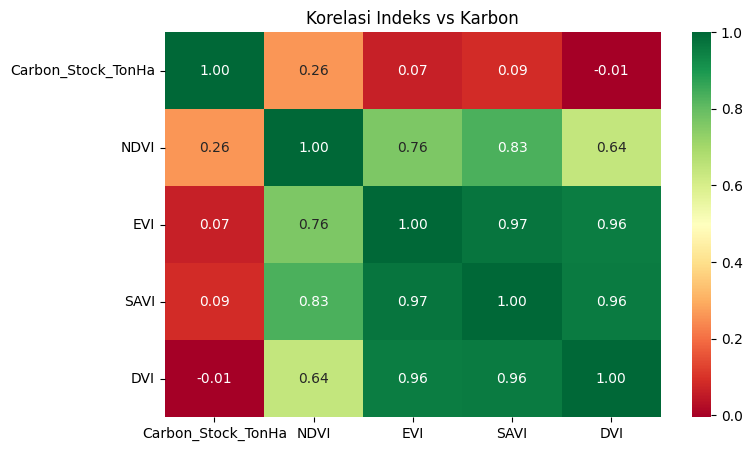

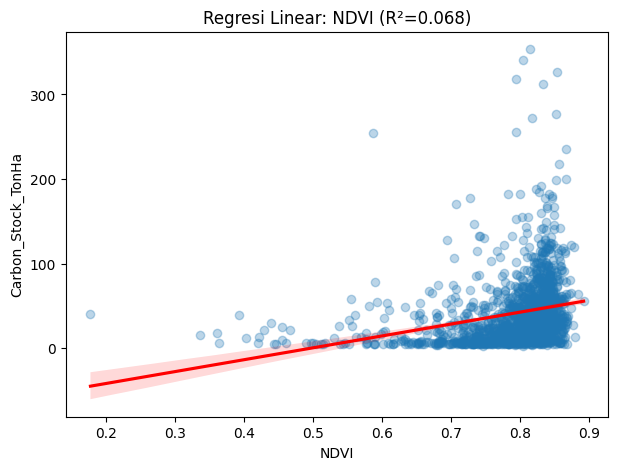

Persamaan: Carbon = (140.6950 * NDVI) + (-69.8775)


In [77]:
# --- CELL 6: ANALISIS ---

# 1. Heatmap
plt.figure(figsize=(8, 5))
cols = ['Carbon_Stock_TonHa', 'NDVI', 'EVI', 'SAVI', 'DVI']
sns.heatmap(df[cols].corr(), annot=True, cmap='RdYlGn', fmt=".2f")
plt.title("Korelasi Indeks vs Karbon")
plt.show()

# 2. Regresi (NDVI)
x_col = 'NDVI'
y_col = 'Carbon_Stock_TonHa'

slope, intercept, r_value, p_value, std_err = stats.linregress(df[x_col], df[y_col])

plt.figure(figsize=(7, 5))
sns.regplot(x=x_col, y=y_col, data=df, line_kws={"color": "red"}, scatter_kws={'alpha':0.3})
plt.title(f"Regresi Linear: NDVI (R²={r_value**2:.3f})")
plt.show()

print(f"Persamaan: Carbon = ({slope:.4f} * NDVI) + ({intercept:.4f})")

In [79]:
# --- CELL 7: PETA FINAL ---

print(f"Membuat peta dengan rumus: {slope:.2f} * NDVI + {intercept:.2f}")

ndvi_highres = s2.normalizedDifference(['B8', 'B4'])

estimated_carbon_map = ndvi_highres.multiply(slope).add(intercept) \
    .max(0) \
    .rename('Estimated_Carbon_Stock')

m = geemap.Map()
m.centerObject(roi, 10) # Zoom out (10) biar keliatan area luasnya

# Sentinel (Max 0.3)
viz_sentinel = {'min': 0, 'max': 0.3, 'bands': ['B4', 'B3', 'B2']}
m.add_layer(s2, viz_sentinel, "Sentinel-2 (Natural Color)")

# GEDI (Max 100)
m.add_layer(carbon_gedi, {'min': 0, 'max': 100, 'palette': ['white', 'green']}, "GEDI Ground Truth")

# Hasil Estimasi (Max 80)
viz_carbon = {
    'min': 0, 'max': 80,
    'palette': ['#ffffcc', '#c2e699', '#78c679', '#31a354', '#006837']
}
m.add_layer(estimated_carbon_map, viz_carbon, "Peta Estimasi Karbon")
m.add_colorbar(viz_carbon, label="Ton C/Ha", layer_name="Peta Estimasi Karbon")

# Layer Batas Merah (Biar lu tau seberapa gede kotaknya)
roi_outline = ee.Image().paint(roi, 0, 3)
m.add_layer(roi_outline, {'palette': 'red'}, "Batas Area Studi")

m

Membuat peta dengan rumus: 140.69 * NDVI + -69.88


Map(center=[-2.30001046260413, 103.3000000000002], controls=(WidgetControl(options=['position', 'transparent_b…

In [81]:
# --- CELL 8: VALIDASI ---
stats = estimated_carbon_map.reduceRegion(
    reducer=ee.Reducer.minMax().combine(ee.Reducer.mean(), sharedInputs=True),
    geometry=roi, scale=100, bestEffort=True, maxPixels=1e9
)
print("Statistik Peta:")
print(stats.getInfo())

Statistik Peta:
{'Estimated_Carbon_Stock_max': 57.03670011877476, 'Estimated_Carbon_Stock_mean': 41.27425363435362, 'Estimated_Carbon_Stock_min': 0}
